## Analysis notebook for atmosphere NetCDF files

### Define utils

In [9]:
%config InlineBackend.figure_format='retina'

import numpy as np
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt

In [10]:
def readncdf(f):

    ds = nc.Dataset(f)
    vars = list(ds.variables.keys())

    nlev_c = len(ds.variables["p"][:])
    nlev_l = len(ds.variables["pl"][:])
    tsurf  = float(ds.variables["tstar"][:])
    psurf  = float(ds.variables["pl"][-1])
    gases  = [str(bytearray(s).decode()).strip() for s in ds.variables["gases"][:]]
    asf    = float(ds.variables["toa_heating"][:])

    data = {
        "nlev_c":       nlev_c,
        "nlev_l":       nlev_l,
        "tstar":        tsurf,
        "psurf":        psurf,
        "gases":        gases,
        "toa_heating":  asf, 
    }

    for k in vars:
        if k in data.keys():
            continue 
        data[k] = np.array(ds.variables[k][:], dtype=float)
    
    ds.close()
    return data

def readrun(f):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")
    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]
    mask = np.argsort(years)
    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([readncdf(f) for f in ncdfs])
    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data


### Do analysis

In [11]:
# Parameters
output1 = "../output/earth_aeolus_steam/"
output2 = "../output/trap1b_aeolus_steam/"

In [12]:
years1, data1 = readrun(output1)
years2, data2 = readrun(output2)

Reading files in '../output/earth_aeolus_steam/'...
    Done reading 767 files
    Final time = 4.895e+06 years
Reading files in '../output/trap1b_aeolus_steam/'...
    Done reading 1053 files
    Final time = 6.938e+06 years


In [13]:
print(data1[0].keys())

dict_keys(['nlev_c', 'nlev_l', 'tstar', 'psurf', 'gases', 'toa_heating', 'p', 'pl', 'tmp', 'tmpl', 'z', 'zl', 'gravity', 'mmw', 'x_gas', 'fl_D_LW', 'fl_U_LW', 'fl_N_LW', 'fl_D_SW', 'fl_U_SW', 'fl_N_SW', 'fl_D', 'fl_U', 'fl_N', 'rad_hr'])


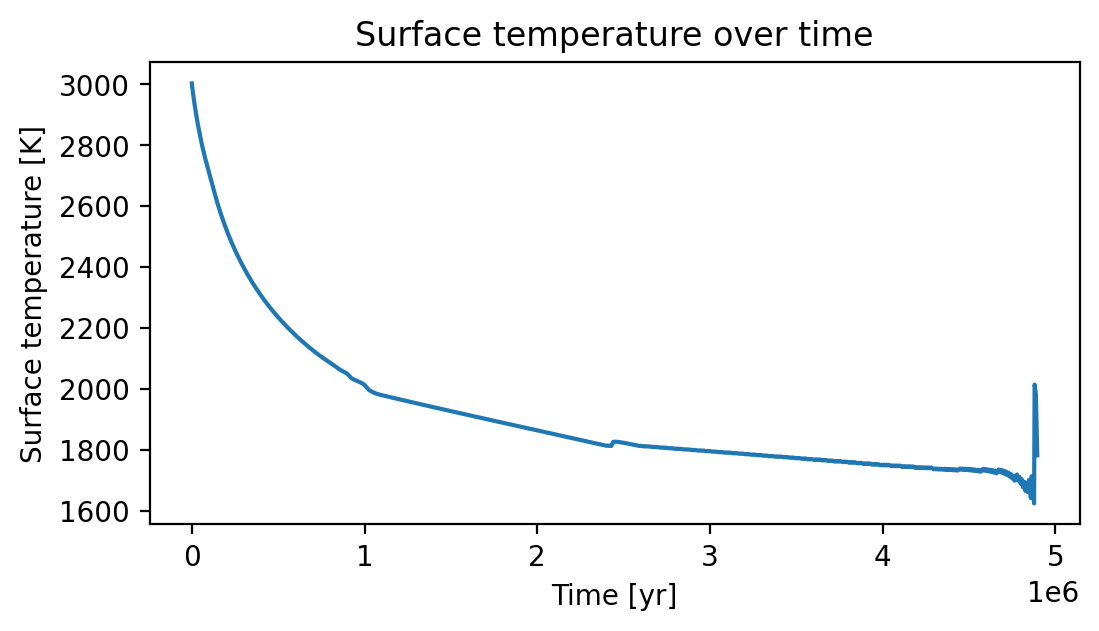

In [14]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(years1, [d["tstar"] for d in data1])
ax.set_xlabel("Time [yr]")
ax.set_ylabel("Surface temperature [K]")
ax.set_title("Surface temperature over time")
plt.show()

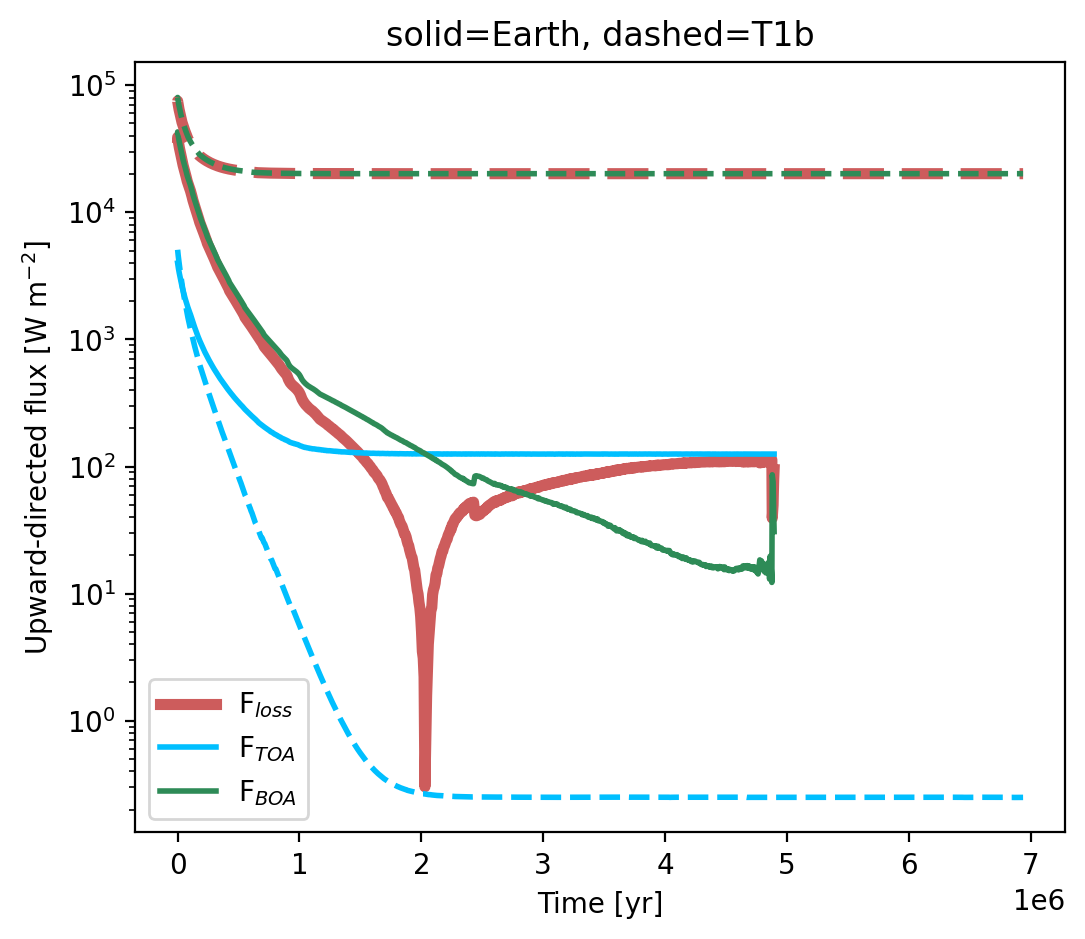

In [24]:
fig,ax = plt.subplots(figsize=(6,5))

lw = 2.0

# Colors
c_toa =  'deepskyblue'
c_boa =  'seagreen'
c_loss = 'indianred'

# Data1
toa  = [d["fl_N"][0] for d in data1]
boa  = [d["fl_N"][-1] for d in data1]
loss = [abs(toa[i]-boa[i]) for i in range(len(toa))]

ax.plot(years1, loss, lw=lw*2, color=c_loss, label="F$_{loss}$")
ax.plot(years1, toa,  lw=lw,   color=c_toa,  label="F$_{TOA}$")
ax.plot(years1, boa,  lw=lw,   color=c_boa,  label="F$_{BOA}$")

# Data2
toa  = [d["fl_N"][0] for d in data2]
boa  = [d["fl_N"][-1] for d in data2]
loss = [abs(toa[i]-boa[i]) for i in range(len(toa))]
ax.plot(years2, loss, lw=lw*2, color=c_loss, linestyle='dashed')
ax.plot(years2, toa,  lw=lw,   color=c_toa,  linestyle='dashed')
ax.plot(years2, boa,  lw=lw,   color=c_boa,  linestyle='dashed')

ax.set_xlabel("Time [yr]")
ax.set_ylabel("Upward-directed flux [W m$^{-2}$]")
ax.set_title("solid=Earth, dashed=T1b")
ax.set_yscale("log")

ax.legend()
plt.show()